# Kaggle Series 8 - Binary Classification on Bank Dataset

In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv("../data/train.csv", index_col='id')
train_data.shape

(750000, 17)

In [3]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


From the Kaggle competion page we get these descriptions:

- age: Age of the client (numeric)
- job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
- marital: Marital status (categorical: "married", "single", "divorced")
- education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
- default: Has credit in default? (categorical: "yes", "no")
- balance: Average yearly balance in euros (numeric)
- housing: Has a housing loan? (categorical: "yes", "no")
- loan: Has a personal loan? (categorical: "yes", "no")
- contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")
- day: Last contact day of the month (numeric, 1-31)
- month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
- duration: Last contact duration in seconds (numeric)
- campaign: Number of contacts performed during this campaign (numeric)
- pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)
- previous: Number of contacts performed before this campaign (numeric)
- poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
- y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

## Examples distribution

How are distributed the examples?

In [4]:
train_data['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

Very bad, the dataset is very umbalanced.

In [5]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0
y,750000.0,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0


In [6]:
# Print unique data for all categoricals
categorical_columns = train_data.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    print(f"Column'{col}': {train_data[col].unique()}")
    for value in train_data[col].unique():
        print(f" - {col}: {value} \t count {train_data[col].value_counts().get(value, 0)} \t ({100* train_data[col].value_counts().get(value, 0) / train_data[col].count()})")

Column'job': ['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']
 - job: technician 	 count 138107 	 (18.414266666666666)
 - job: blue-collar 	 count 170498 	 (22.733066666666666)
 - job: student 	 count 11767 	 (1.5689333333333333)
 - job: admin. 	 count 81492 	 (10.8656)
 - job: management 	 count 175541 	 (23.405466666666666)
 - job: entrepreneur 	 count 17718 	 (2.3624)
 - job: self-employed 	 count 19020 	 (2.536)
 - job: unknown 	 count 2917 	 (0.38893333333333335)
 - job: services 	 count 64209 	 (8.5612)
 - job: retired 	 count 35185 	 (4.691333333333334)
 - job: housemaid 	 count 15912 	 (2.1216)
 - job: unemployed 	 count 17634 	 (2.3512)
Column'marital': ['married' 'single' 'divorced']
 - marital: married 	 count 480759 	 (64.1012)
 - marital: single 	 count 194834 	 (25.977866666666667)
 - marital: divorced 	 count 74407 	 (9.920933333333334)
Column'education': ['secondary' 'pri

## Preprocessing and feature selection

### Dropping
- `poutcome` is kinda useless since it's mostly unknown for most of the examples.

### Encoding
Some of the features are categorical, we can split them in nominal and ordinal:

- nominal: `job`, `marital`, `contact`
- ordinal: `education`

Let's plot densities

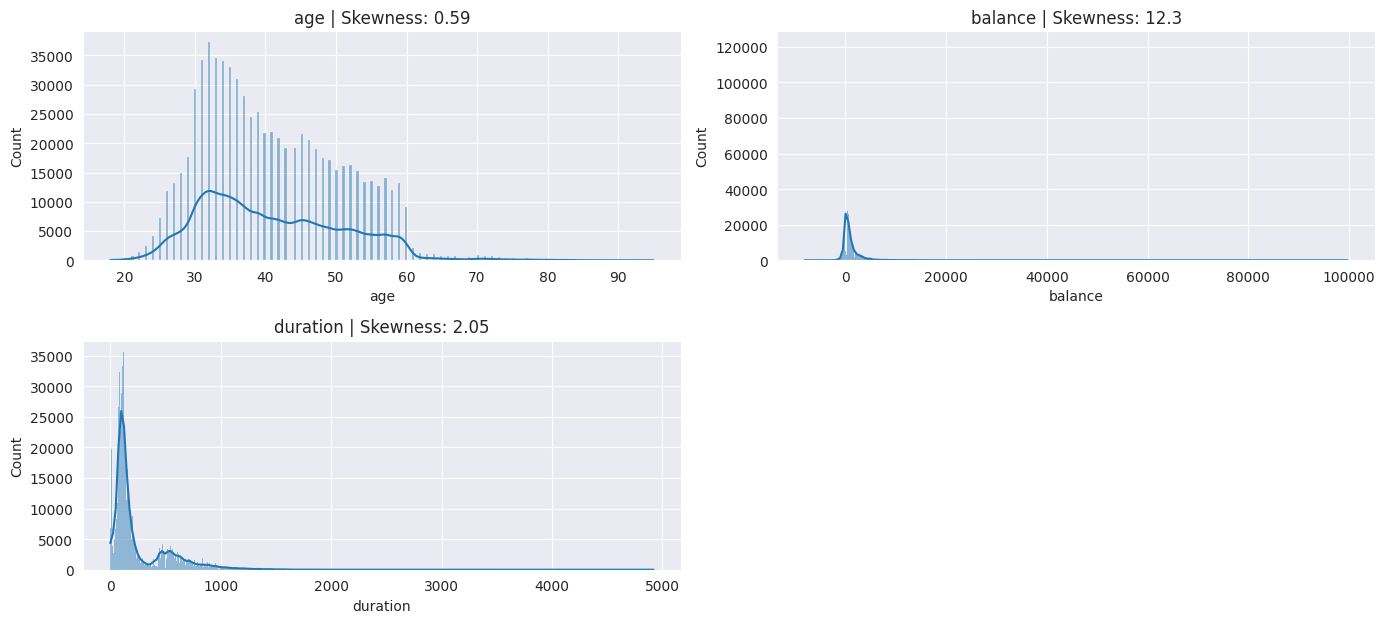

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

numerical_columns = ['age', 'balance', 'duration']

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(train_data[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

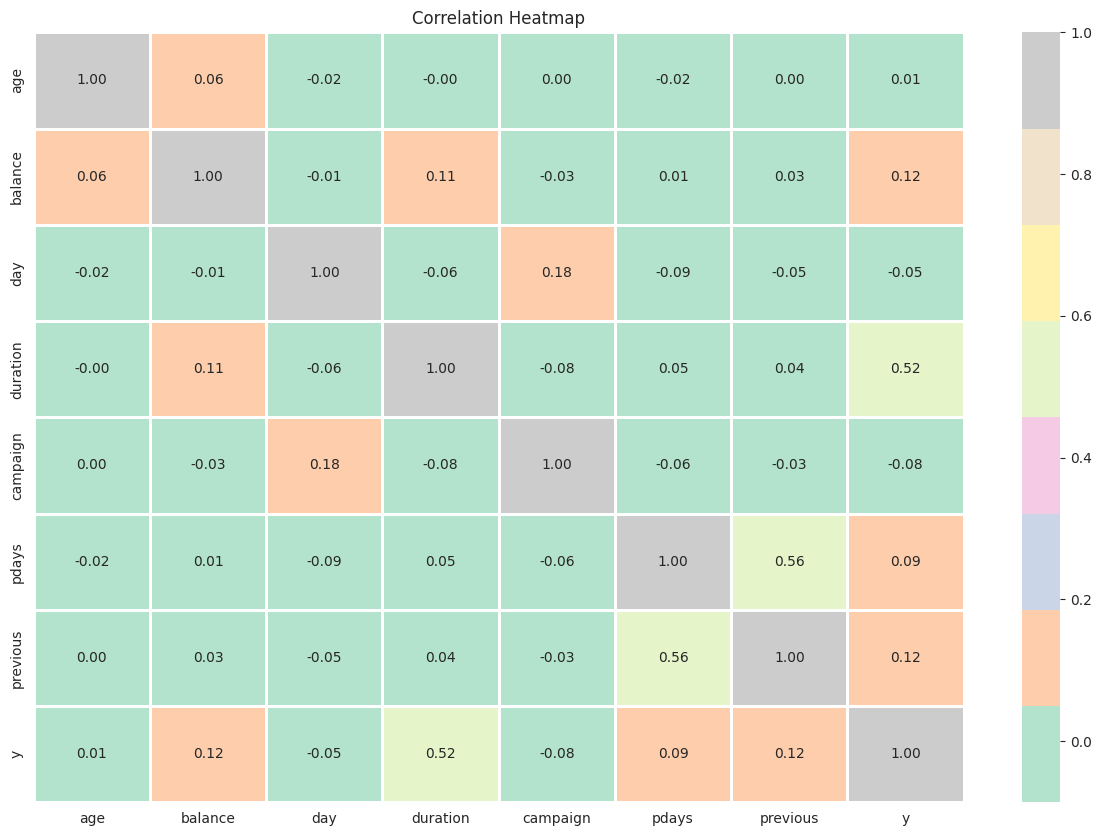

In [8]:
plt.figure(figsize=(15, 10))


numerical_data = train_data.select_dtypes(include=["float64", "int64"])
sns.heatmap(numerical_data.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

In [47]:
# Encode some colums with dummy encoding

nominal_columns = ['job', 'marital', 'contact']
ordinal_columns = ['education']

train_data = train_data[train_data['education'] != "unknown"]
encoded = pd.get_dummies(train_data, columns=nominal_columns, drop_first=True)
encoded['education'] = encoded['education'].replace({
    "primary": 1,
    "secondary": 2,
    "tertiary": 3
})
encoded['housing'] = encoded['housing'].replace({"no": False, "yes": True})
encoded['loan'] = encoded['loan'].replace({"no": False, "yes": True})
encoded['default'] = encoded['default'].replace({"no": False, "yes": True})

/tmp/ipykernel_1734808/476657716.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded['education'] = encoded['education'].replace({
/tmp/ipykernel_1734808/476657716.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded['housing'] = encoded['housing'].replace({"no": False, "yes": True})
/tmp/ipykernel_1734808/476657716.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in t

In [48]:
training_data_x = encoded
training_data_x = training_data_x.drop(columns=['poutcome', 'day', 'month', 'y'])
training_data_y = encoded['y']

In [50]:
training_data_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728701 entries, 0 to 749999
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   age                728701 non-null  int64
 1   education          728701 non-null  int64
 2   default            728701 non-null  bool 
 3   balance            728701 non-null  int64
 4   housing            728701 non-null  bool 
 5   loan               728701 non-null  bool 
 6   duration           728701 non-null  int64
 7   campaign           728701 non-null  int64
 8   pdays              728701 non-null  int64
 9   previous           728701 non-null  int64
 10  job_blue-collar    728701 non-null  bool 
 11  job_entrepreneur   728701 non-null  bool 
 12  job_housemaid      728701 non-null  bool 
 13  job_management     728701 non-null  bool 
 14  job_retired        728701 non-null  bool 
 15  job_self-employed  728701 non-null  bool 
 16  job_services       728701 non-null  bool 
 

In [ ]:
print(f"Positive examples {sum(training_data_y >=0.7) / len(training_data_y)}")
print(f"Negative examples {sum(training_data_y <=0.7) / len(training_data_y)}")

Esempi positivi 0.12027841323121555
Esempi negativi 0.8797215867687844
